In [79]:
import numpy as np
import matplotlib.pyplot as plt

In [80]:


def ackley_fitness(X, a=20.0, b=0.2):
    """
    Función de Ackley (variante con cos(n*pi*x_i)) para usar como función objetivo.

    Acepta:
      - X shape (r,)        -> r individuos 1D (n=1)
      - X shape (r,n)       -> r individuos de n variables
      - (x1, x2, ..., xn)   -> tuplas/listas de arrays (se apilan por columnas)

    Retorna:
      - ndarray shape (r,) con f(x) por individuo.
    """
    # Si me pasan (x1, x2, ...) los convierto en matriz de (r,n)
    if isinstance(X, (list, tuple)) and len(X) > 0 and np.ndim(X[0]) == 1:
        X = np.column_stack(X)

    X = np.asarray(X, dtype=float)

    # Si es solo un vector 1D, conviértelo en matriz (r,1) para unificar lógica
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    n = X.shape[1]  # número de variables (1 o 2)
    sum_sq = np.sum(X**2, axis=1)
    term1 = -a * np.exp(-b * np.sqrt(sum_sq / n))
    term2 = -np.exp(np.sum(np.cos(n * np.pi * X), axis=1) / n)
    return term1 + term2 + a + np.e

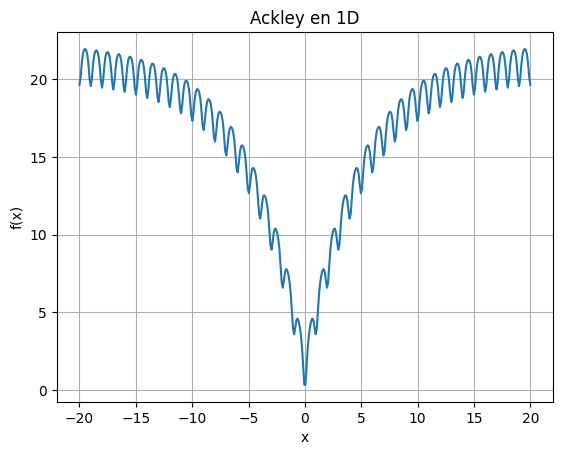

In [81]:

def fx(X):
    return ackley_fitness(X)


# Dominio en 1D
x = np.linspace(-20, 20, 400)
x1 = np.linspace(-20, 20, 400)


y = fx((x,x1))

# Graficar
plt.plot(x, y)
plt.title("Ackley en 1D")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.show()

In [82]:
# FUNCION PARA INICIAR POBLACION
def iniciar_población(numero_individuos, longitud_cromosoma):
    return  np.random.randint(0,2,size=(numero_individuos,longitud_cromosoma))

In [83]:
# FUNCIÓN PARA DECODIFICAR DE BINARIO A DECIMAL LOS INDIVIDUOS
def decodificar(poblacion, min, max):
    [renglones,columnas] = poblacion.shape
    decimal = np.zeros(renglones)
    decimal_rescalado = np.zeros(renglones)
    
    for i in range(renglones):
        for j in range(columnas):
            # Se transforma de binario a decimal entero
            decimal[i] += poblacion[i,j]*2**(columnas-j-1)
            
            # Se rescalan los valores al rango de busqueda
            decimal_rescalado[i] = (max-min)*decimal[i]/(2**columnas-1) + min
            
    return decimal_rescalado



In [84]:
# FUNCIÓN PARA OBTENER LAS APTITUDES (FITNESS) DE CADA INDIVIDUO

def fitness(poblacion, min, max):
    [renglones,columnas] = poblacion.shape
    x = decodificar(poblacion,min,max)
    fitness = -(0.1 + (1-x)**2 - 0.1*np.cos(6*np.pi*(1-x))) + 2
    return fitness

In [85]:
# FUNCIÓN DE CRUZAMIENTO (SINGLE POINT)
def cruzamiento(poblacion,pares_de_cromosomas:int):
    [renglones,columnas] = poblacion.shape
    if pares_de_cromosomas > renglones/2:
        raise ValueError("El numero de pares de cromosomas debe ser menor a la mitad del numero de individuos")
    M = np.zeros((2*pares_de_cromosomas,columnas)) # Matriz de hijos
    for i in range(pares_de_cromosomas):
        r1 = np.random.randint(0,renglones,size=(1,2)) # Par de numeros aleatorios para seleccionar padres
        r2 = np.random.randint(0,columnas) # Punto de cruzamiento
        
        # Selecionamos los padres a cruzar

        
        padre_1 = poblacion[r1[0,0],:]
        padre_2 = poblacion[r1[0,1],:]
        
        # Se crean los hijos
        hijo_1 = np.concatenate((padre_1[0:r2], padre_2[r2:]))
        hijo_2 = np.concatenate((padre_2[0:r2], padre_1[r2:]))
        
        # Guardar a mis hijos
        M[2*i,:] = hijo_1
        M[2*i+1,:] = hijo_2
    return M


        
        

In [86]:
# FUNCIÓN QUE HACE LA REPRESENTACIÓN DE MUTACIÓN DE CROMOSOMAS
def mutacion(poblacion,tasa_mutacion):
    [renglones,columnas] = poblacion.shape
    n = int(tasa_mutacion*columnas)
    for i in range(n):
        individuo_rand = np.random.randint(0,renglones) # Selecciona un individuo al azar
        gen_rand = np.random.randint(0,columnas) # Selecciona un gen al azar

        match poblacion[individuo_rand,gen_rand]:
            case 0:
                poblacion[individuo_rand,gen_rand] = 1
            case 1:
                poblacion[individuo_rand,gen_rand] = 0
                    
    return poblacion


In [87]:
# FUNCIÓN DE SELECCIÓN POR ORDEN LINEAL (RANKING)
def seleccion_ranking(poblacion, porcentaje_seleccion,min,max):
    [renglones,columnas] = poblacion.shape
    nueva_poblacion = np.zeros((renglones,columnas))
    n = int(porcentaje_seleccion*renglones)
    aptitud = fitness(poblacion,min,max).reshape(renglones,1)
    poblacion_ampliada = np.concatenate([poblacion,aptitud],axis=1)
    indices = np.argsort(poblacion_ampliada[:,-1])[::-1]
    poblacion_ordenada = poblacion_ampliada[indices]
    poblacion_seleccionada = poblacion_ordenada[:n,:]
    poblacion_ordenada_final = poblacion_seleccionada[:,0:columnas]
    
    for r in range(renglones):
        for c in range(columnas):
            # Rellena la nueva población con los mejores individuos y el resto con individuos aleatorios
            if r < n:
                nueva_poblacion[r,c] = poblacion_ordenada_final[r,c]
            else:
                nueva_poblacion[r,c] = np.random.randint(0,2)
                
    return nueva_poblacion


In [88]:
# SELECCION POR TORNEO

# Seleccion por torneo
def seleccion_torneo(poblacion, Imin, Imax,k : int):
  '''
  poblacion: poblacion de individuos en binario
  k: Tamanio del torneo
  '''
  [r,c] = poblacion.shape
  aptitud = fitness(poblacion, Imin, Imax).reshape(r,1)
  M = np.concatenate([poblacion,aptitud],axis=1)
  
  # Seleccionamos los k individuos
  indices = np.random.choice(r,size=k,replace=False)
  torneo = M[indices,:]
  # Ordenamos ppor aptitud descendente
  indices = np.argsort(torneo[:,-1])[::-1]
  torneo_ordenado = torneo[indices]
  # Seleccionamos el mejor individuo
  mejor_individuo = torneo_ordenado[0,0:c]
  return mejor_individuo


# FUNCION QUE CREA UNA NUEVA POBLACION A PARTIR DEL TORNEO
def nueva_poblacion_torneo(poblacion, k:int,min,max):
    [renglones,columnas] = poblacion.shape
    nueva_poblacion = np.zeros((renglones,columnas))
    
    # Se repite el torneo
    for i in range(renglones):
        nueva_poblacion[i,:] = seleccion_torneo(poblacion,k,min,max)
    return nueva_poblacion
    

In [89]:
# SELECCION POR RULETA
def seleccion_ruleta(poblacion,min,max):
    [renglones,columnas] = poblacion.shape
    aptitud = fitness(poblacion,min,max)
    min_fitness = np.min(aptitud)
    
    if (min_fitness < 0):
        aptitud = aptitud - min_fitness + 1e-6
    if (np.sum(aptitud) == 0):
        probabilidad = np.ones(renglones)/renglones
    else:
        probabilidad = aptitud/np.sum(aptitud)
    
    # Obtenemos las probabilidades acumuladas
    acumuladas = np.cumsum(probabilidad)
    # Generamos un random num para simular la rotación de la ruleta
    num = np.random.rand()

    # Se busca el individuo donde cae el número aleatorio
    for i in range(renglones):
        if num < acumuladas[i]:
            ganador = poblacion[i,:]
            break
    return ganador


# Nueva población por ruleta
def nueva_poblacion_ruleta(poblacion,min,max):
    [renglones,columnas] = poblacion.shape
    nueva_poblacion = np.zeros((renglones,columnas))

    for i in range(renglones):
        nueva_poblacion[i,:] = seleccion_ruleta(poblacion,min,max)
    return nueva_poblacion

In [91]:
# IMPLEMENTACIÓN
print("IMPLEMENTACIÓN")


# ================== PARAMETROS DE ARRANQUE ==================
numero_individuos = 60
longitud_cromosoma = 12
generaciones = 50
porcentaje_seleccion = 0.6
par_cromosomas = int(numero_individuos/2)
tasa_mutacion = 0.01 # Esto requiere ser un valor entre bajo
max = 5
min = -max
tamaño_torneo=3



# ================== ALGORITMO GENÉTICO ==================

# PASO 1 | Creamos la población
poblacion = iniciar_población(numero_individuos,longitud_cromosoma)
print(f"[PASO 1] Población inicial: \n{poblacion}\n")


for i in range(generaciones):
    print(f"========= Generación {i+1}\n")
    # Paso 2 | Aplicamos el cruzamiento
    cruza = cruzamiento(poblacion,par_cromosomas)
    print(f"[PASO 2] Población después del cruzamiento: \n{cruza[:5]}\n")

    # Paso 3 | Aplicamos la mutación
    mutados = mutacion(cruza,tasa_mutacion)
    print(f"[PASO 3] Población después de la mutación: \n{mutados}\n")

    # Paso 4 | Selección de la nueva generación
    #seleccion = seleccion_ranking(mutados,porcentaje_seleccion,min,max)
    #seleccion = nueva_poblacion_torneo(mutados, k=tamaño_torneo, min=min, max=max)
    seleccion = nueva_poblacion_ruleta(mutados, min=min, max=max)
    print(f"[PASO 4] Población de la nueva generación: \n{seleccion}\n")

    poblacion = seleccion

# ================= RESULTADOS =================
poblacion_mejor = decodificar(poblacion, min, max)
individuo_mejor = poblacion_mejor[0]
print(f"El mejor individuo es: {individuo_mejor}")
print(f"El gen es: {poblacion[0,:]}")

# TODO hacer un graficador de empalmar el mejor valor de aptitud o un historico para ver como progresa la aptitud


IMPLEMENTACIÓN
[PASO 1] Población inicial: 
[[0 0 0 1 1 0 0 1 1 1 0 1]
 [1 0 1 1 0 0 0 0 1 1 1 1]
 [1 0 0 1 0 0 1 0 1 1 1 0]
 [1 1 1 1 0 0 1 1 0 1 1 0]
 [0 1 0 1 0 1 1 0 0 1 0 0]
 [1 0 0 0 1 0 1 1 0 0 0 0]
 [1 1 0 0 0 1 1 1 0 0 1 0]
 [0 1 1 1 1 0 0 1 1 0 1 1]
 [0 0 1 1 1 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 1 0 1 0 1 0]
 [1 0 1 0 1 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1]
 [0 1 0 1 0 0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0 1 1 1 1 0]
 [1 0 0 0 1 1 0 1 0 0 0 1]
 [0 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0]
 [1 0 0 1 1 1 1 1 1 1 0 1]
 [1 1 1 0 1 0 0 1 1 0 0 1]
 [0 0 0 0 0 1 0 0 1 0 0 1]
 [0 1 0 1 0 1 1 0 0 0 0 0]
 [1 0 1 1 0 1 1 1 1 0 1 0]
 [1 0 1 0 1 0 0 0 1 1 1 0]
 [1 0 1 0 1 0 1 1 0 0 1 1]
 [0 0 0 1 0 1 0 0 1 0 0 1]
 [0 1 0 0 1 0 0 1 0 0 0 0]
 [1 1 0 0 1 0 0 0 0 0 1 1]
 [1 0 1 0 0 1 0 0 1 1 0 0]
 [0 0 1 0 1 0 0 1 0 1 1 0]
 [1 0 1 0 0 0 1 0 1 0 1 0]
 [1 0 1 1 1 1 1 1 0 0 0 1]
 [0 0 0 0 1 1 1 1 0 1 1 1]
 [0 0 1 0 0 1 1 0 0 1 1 0]
 [0 1 1 0 1 1 1 1 1 1 0 1]
 [0 0 0 0 0 1 0 1 1 0 0 1]
 [1 0 1 0 1